<a href="https://colab.research.google.com/github/yugshah7777/SpyD_SIH/blob/main/models/arimasSarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import yfinance as yf
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
ticker = 'AAPL'
end_date = date.today()
start_date = end_date - timedelta(days=10 * 365)

data = yf.download(ticker, start=start_date, end=end_date)
close_price = data[['Close']]

print(f"Fetched {len(close_price)} points from {start_date} to {end_date}.")

/tmp/ipython-input-2725102965.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fetched 2513 points from 2015-09-21 to 2025-09-18.


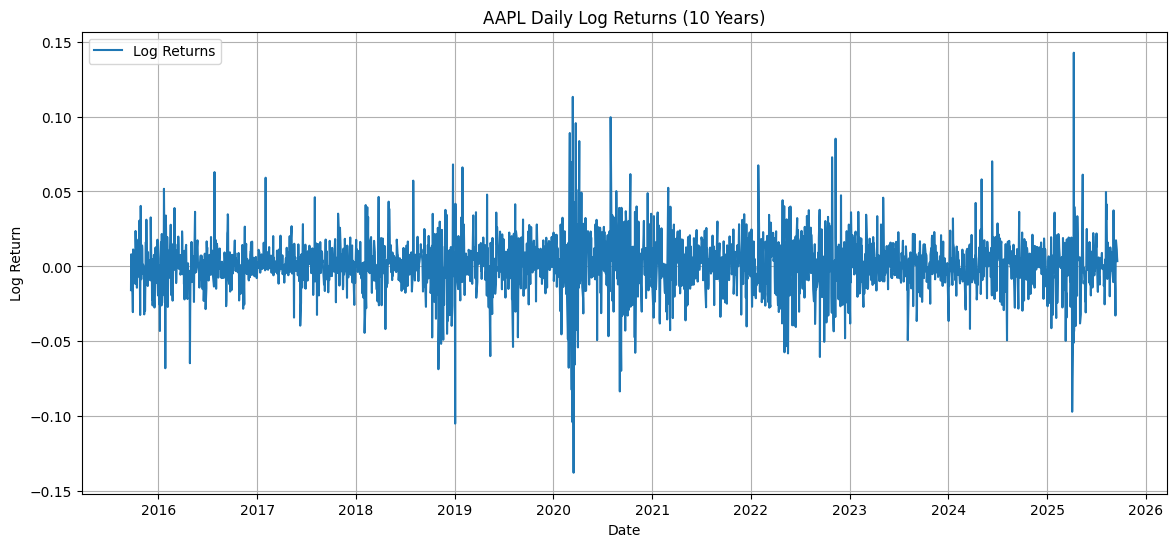

In [41]:
log_return = np.log(close_price['Close']).diff().dropna()

plt.figure(figsize=(14, 6))
plt.plot(log_return.index, log_return, label='Log Returns')
plt.title('AAPL Daily Log Returns (10 Years)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
result = adfuller(log_return)
print("\n--- ADF Test on Log Returns ---")
print(f"p-value: {result[1]:.4f}")
print("Stationary ✅" if result[1] <= 0.05 else "Non-stationary ❌")


--- ADF Test on Log Returns ---
p-value: 0.0000
Stationary ✅


In [43]:
train_size = int(len(log_return) * 0.8)
train, test = log_return[:train_size], log_return[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 2009, Test size: 503


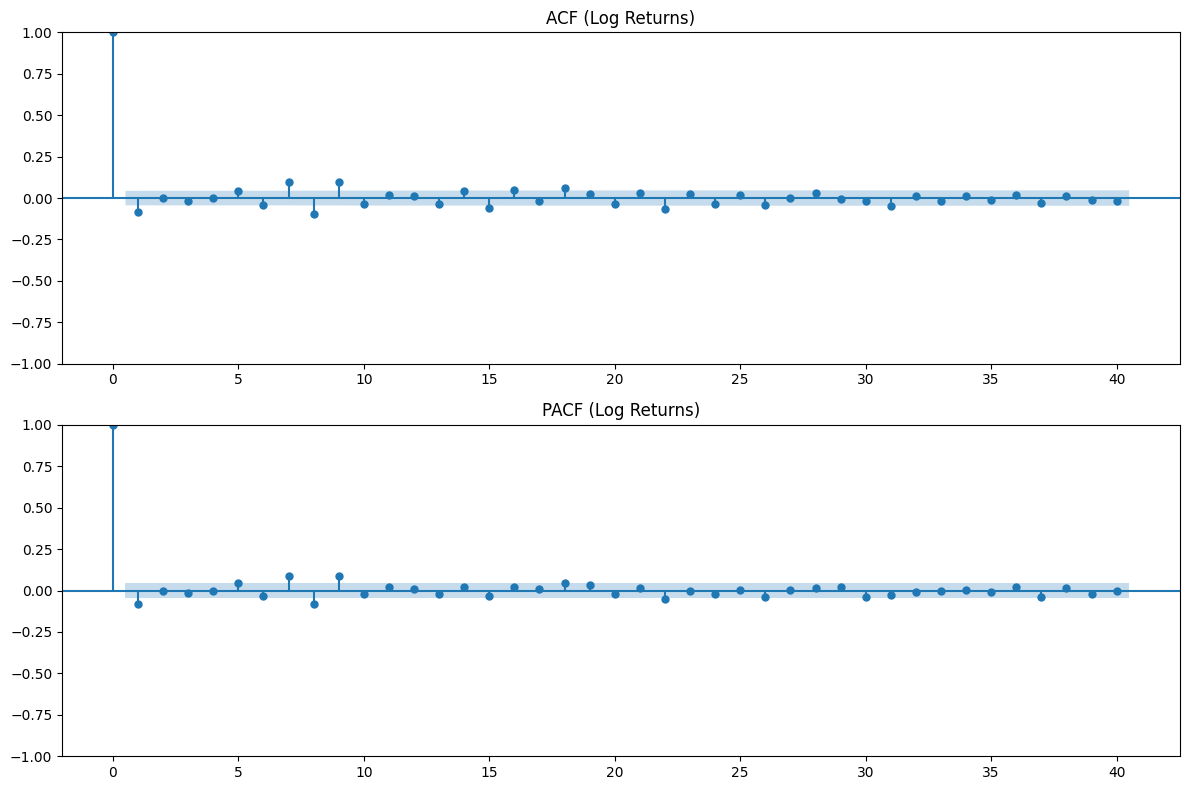

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax1, lags=40)
ax1.set_title('ACF (Log Returns)')
plot_pacf(train, ax=ax2, lags=40)
ax2.set_title('PACF (Log Returns)')
plt.tight_layout()
plt.show()

In [45]:
stepwise_model = auto_arima(train,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            d=None,
                            seasonal=False,
                            stepwise=True,
                            suppress_warnings=True,
                            information_criterion='aic')

print("\n--- Best Model ---")
print(stepwise_model.summary())
order = stepwise_model.order
print(f"Using ARIMA order: {order}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12


--- Best Model ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2009
Model:               SARIMAX(0, 0, 1)   Log Likelihood                5159.974
Date:                Thu, 18 Sep 2025   AIC                         -10313.947
Time:                        09:08:40   BIC                         -10297.131
Sample:                             0   HQIC                        -10307.774
                               - 2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.442      0.015       0.000       0.002
ma.L1         -0.0820      0.015     -5.641      0.000      -0.110      -0.054
sigma2         0.0003   6.16e-06

In [46]:
model = ARIMA(train, order=order)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2009
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5159.974
Date:                Thu, 18 Sep 2025   AIC                         -10313.947
Time:                        09:08:41   BIC                         -10297.131
Sample:                             0   HQIC                        -10307.774
                               - 2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.449      0.014       0.000       0.002
ma.L1         -0.0820      0.015     -5.646      0.000      -0.111      -0.054
sigma2         0.0003   6.16e-06     55.827      0.0

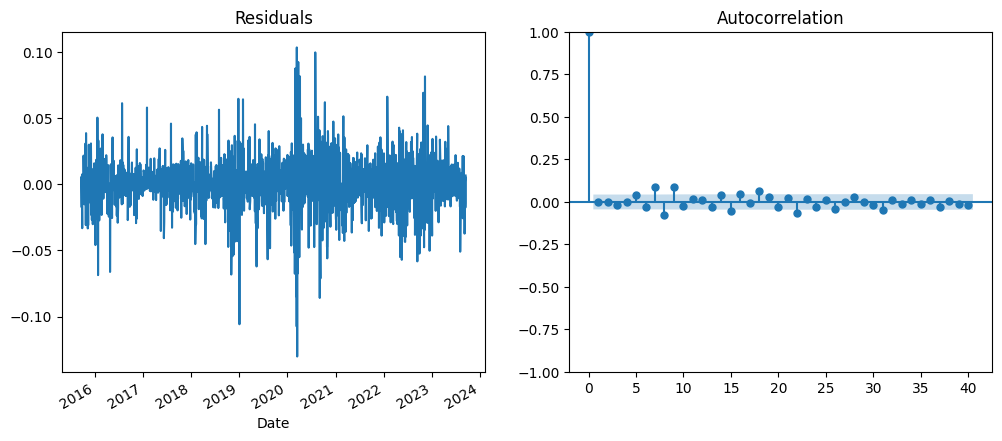

In [47]:
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(12,5))
residuals.plot(title="Residuals", ax=ax[0])
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1])
plt.show()

In [48]:
n_steps = len(test)
fc_obj = model_fit.get_forecast(steps=n_steps)
pred_mean = fc_obj.predicted_mean
pred_ci = fc_obj.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [49]:
pred_mean.index = test.index
pred_ci.index = test.index

In [50]:
rmse = np.sqrt(mean_squared_error(test, pred_mean))
mae = mean_absolute_error(test, pred_mean)
print(f"\nRMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")


RMSE: 0.017293
MAE: 0.011517


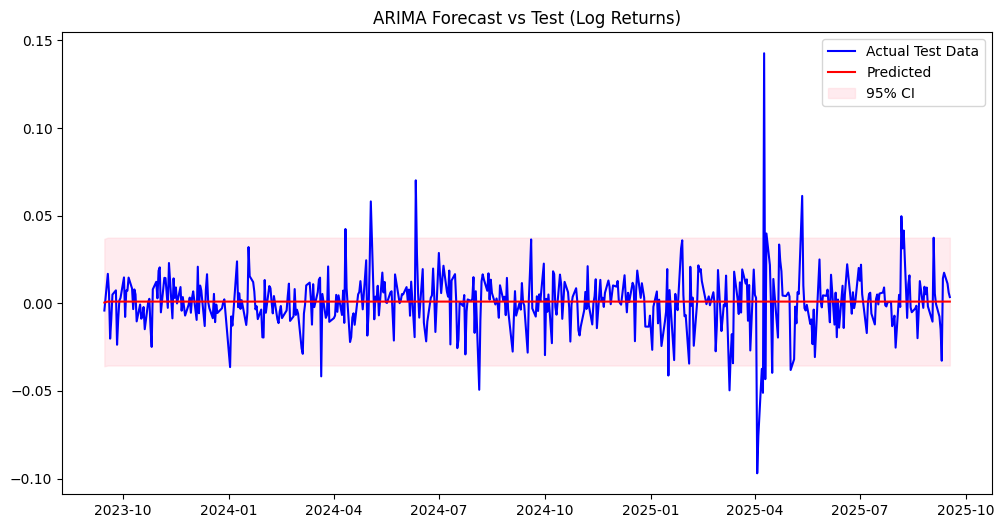

In [51]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual Test Data', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Predicted', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1],
                 color='pink', alpha=0.3, label='95% CI')
plt.title('ARIMA Forecast vs Test (Log Returns)')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


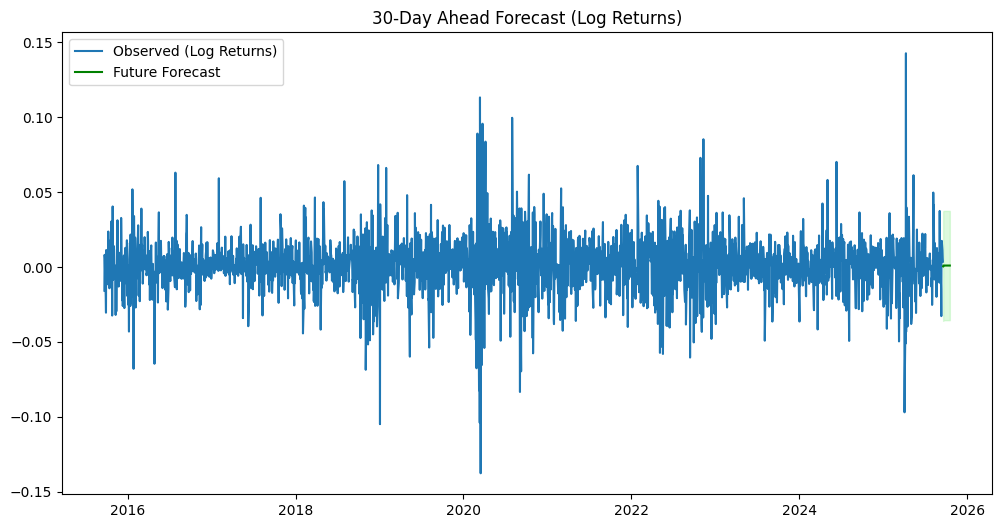

In [52]:
future_steps = 30
future_forecast = model_fit.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(log_return.index, log_return, label='Observed (Log Returns)')
plt.plot(pd.date_range(log_return.index[-1], periods=future_steps+1, freq='D')[1:],
         future_mean, label='Future Forecast', color='green')
plt.fill_between(pd.date_range(log_return.index[-1], periods=future_steps+1, freq='D')[1:],
                 future_ci.iloc[:,0], future_ci.iloc[:,1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("30-Day Ahead Forecast (Log Returns)")
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

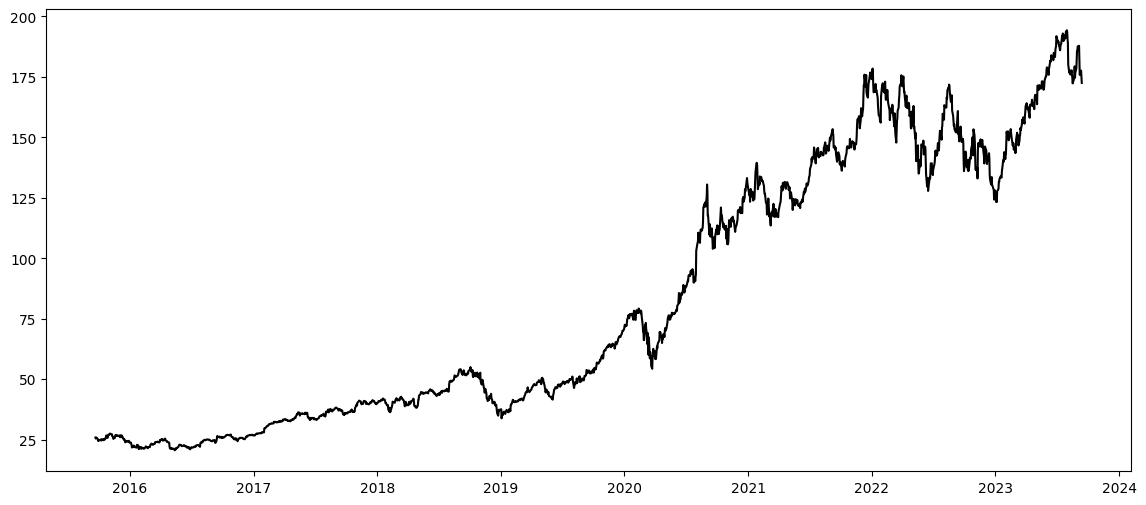

In [57]:
# ----------------------------
# 13. Reconstruct Prices from Returns
# ----------------------------

last_train_price = close_price['Close'].iloc[train_size - 1]

# Cumulative sums of log returns
predicted_log_returns_cumsum = np.cumsum(pred_mean)
actual_log_returns_cumsum = np.cumsum(test.loc[:, 'AAPL'])

# Drop the first element to match test index length
predicted_prices = last_train_price * np.exp(predicted_log_returns_cumsum.iloc[1:])
actual_prices = last_train_price * np.exp(actual_log_returns_cumsum.iloc[1:])

# Align indices
predicted_prices.index = test.index
actual_prices.index = test.index

# Confidence intervals
pred_ci_prices_lower = last_train_price * np.exp(np.cumsum(pred_ci.iloc[:, 0])).iloc[1:]
pred_ci_prices_upper = last_train_price * np.exp(np.cumsum(pred_ci.iloc[:, 1])).iloc[1:]

pred_ci_prices_lower.index = test.index
pred_ci_prices_upper.index = test.index

# ----------------------------
# 14. Final Plot
# ----------------------------
plt.figure(figsize=(14,6))
plt.plot(close_price.index[:train_size], close_price['Close'][:train_size],
         label='Training Data', color='black')
plt.plot(actual_prices.index, actual_prices,
         label='Actual Test Prices', color='blue')
plt.plot(predicted_prices.index, predicted_prices,
         label='Predicted Prices', color='red')

# Use test.index here to avoid length mismatch
plt.fill_between(test.index,
                 pred_ci_prices_lower,
                 pred_ci_prices_upper,
                 color='pink', alpha=0.3, label='95% CI')

plt.title('AAPL Stock Price Forecast (Train vs Actual vs Predicted)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
